# Description

A simple model to predict a stock's price given its recent price history.


# Versions
## v1
- Context window: 8 days price history
- Linear model predicts next day price
- L2 loss
- Naive strategy of holding stock iff predicted price for day went up
- Table comparing return vs baselines: always hold, and mean price predictor

In [1]:
from matplotlib import pyplot as plt

%matplotlib inline

import pandas as pd
import torch as th
import numpy as np

plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

# Dataset

In [2]:
from dataclasses import dataclass

batch_size = 128
hist_win = 8
pred_win = 1

@dataclass
class DateRange:
  """Specifies a range of dates, using [start, end)."""
  start: str = None
  end: str = None

train_date_range = DateRange('2003-01-01', '2017-01-01')
eval_date_range = DateRange('2017-01-01', '2020-01-01')

In [3]:
def load_df(ticker, date_range: DateRange):
  """Loads the DataFrame for ticker between [start_date, end_date)."""
  df = pd.read_csv(f'~/data/zetaqubit/trading/kaggle/full_history/{ticker}.csv')
  df['date'] = pd.to_datetime(df['date'])
  if date_range.start:
    df = df.query(f'date >= "{date_range.start}"')
  if date_range.end:
    df = df.query(f'date < "{date_range.end}"')
  # reverse so oldest is first
  df = df.iloc[::-1].reset_index(drop=True)
  return df

df = load_df('GOOG', train_date_range)
df.head(10)

,date,volume,open,high,low,close,adjclose
0,2004-08-19,44871300,49.813286,51.835709,47.800831,49.982655,49.982655
1,2004-08-20,22942800,50.316402,54.336334,50.062355,53.952770,53.952770
2,2004-08-23,18342800,55.168217,56.528118,54.321388,54.495735,54.495735
3,2004-08-24,15319700,55.412300,55.591629,51.591621,52.239193,52.239193
4,2004-08-25,9232100,52.284027,53.798351,51.746044,52.802086,52.802086
5,2004-08-26,7128600,52.279045,53.773445,52.134586,53.753517,53.753517
6,2004-08-27,6241200,53.848164,54.107193,52.647663,52.876804,52.876804
7,2004-08-30,5221400,52.443428,52.548038,50.814533,50.814533,50.814533
8,2004-08-31,4941200,50.958992,51.661362,50.889256,50.993862,50.993862
9,2004-09-01,9181600,51.158245,51.292744,49.648903,49.937820,49.937820


In [4]:
df.tail(10)

,date,volume,open,high,low,close,adjclose
3105,2016-12-16,2443800,800.400024,800.856018,790.289978,790.799988,790.799988
3106,2016-12-19,1232100,790.219971,797.659973,786.270020,794.200012,794.200012
3107,2016-12-20,951000,796.760010,798.650024,793.270020,796.419983,796.419983
3108,2016-12-21,1211300,795.840027,796.676025,787.099976,794.559998,794.559998
3109,2016-12-22,972200,792.359985,793.320007,788.580017,791.260010,791.260010
3110,2016-12-23,623400,790.900024,792.739990,787.280029,789.909973,789.909973
3111,2016-12-27,789100,790.679993,797.859985,787.656982,791.549988,791.549988
3112,2016-12-28,1153800,793.700012,794.229980,783.200012,785.049988,785.049988
3113,2016-12-29,744300,783.330017,785.929993,778.919983,782.789978,782.789978
3114,2016-12-30,1770000,782.750000,782.780029,770.409973,771.820007,771.820007


In [5]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

# Caveats
#   - looks at only 1 column
class StockSeqDataset(Dataset):
    def __init__(self, df, column='adjclose', hist_win=hist_win, pred_win=pred_win):
        self.df = df
        self.col = column
        self.hist_win = hist_win
        self.pred_win = pred_win
    
    def __getitem__(self, index):
        assert 0 <= index < len(self)
        x_end = index + self.hist_win
        x = self.df.iloc[index:x_end][self.col]
        y = self.df.iloc[x_end:x_end+self.pred_win][self.col]
        return (th.from_numpy(np.array(x, dtype=np.float32)),
                th.from_numpy(np.array(y, dtype=np.float32)))
    
    def __len__(self):
        return len(self.df) - self.hist_win - self.pred_win + 1

ds = StockSeqDataset(df)

dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=True)

In [6]:
ds[0]

(tensor([49.9827, 53.9528, 54.4957, 52.2392, 52.8021, 53.7535, 52.8768, 50.8145]),
 tensor([50.9939]))

In [7]:
for x, y in dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([128, 8])
torch.Size([128, 1])


# Model

In [8]:
model = th.nn.Sequential(
    th.nn.Linear(hist_win, pred_win),
    #th.nn.ReLU(),
    #th.nn.Linear(100, pred_win),
)

loss_fn = th.nn.MSELoss()

learning_rate = 0.005
optimizer = th.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.5))
lr_schedule = th.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

steps = 50
for epoch in range(steps):
    loss_avg = 0
    for x, y in dl:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        loss_avg += loss.item()
        #print(loss.item())
    lr_schedule.step()
    print(f'{lr_schedule.get_lr()[0]:.5f} {loss_avg / len(dl)}')

/home/z/tools/conda/envs/trading/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:595: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


0.00405 135.46750518798828
0.00365 125.60798736572265
0.00328 123.34597290039062
0.00295 116.95805191040039
0.00266 113.63798614501952
0.00239 113.56078659057617
0.00215 110.11511306762695
0.00194 110.13216064453125
0.00174 109.57348876953125
0.00157 105.63393600463867
0.00141 104.80186126708985
0.00127 104.76990234375
0.00114 103.93078353881836
0.00103 101.38063125610351
0.00093 99.91065628051757
0.00083 101.00399871826171
0.00075 100.24038970947265
0.00068 98.98553756713868
0.00061 98.33415222167969
0.00055 97.79507308959961
0.00049 96.61323959350585
0.00044 96.54659027099609
0.00040 98.9584700012207
0.00036 96.72092391967773
0.00032 96.4173258972168
0.00029 95.05152404785156
0.00026 95.05673324584961
0.00024 95.67247833251953
0.00021 96.50325622558594
0.00019 100.8198309326172
0.00017 96.86321716308593
0.00015 97.45383682250977
0.00014 93.62998916625976
0.00013 93.55347076416015
0.00011 93.16908569335938
0.00010 96.17081726074218
0.00009 93.10479537963867
0.00008 96.46008422851563
0

In [9]:
lr_schedule.get_lr()

[2.3191988432940557e-05]

In [10]:
y.t()

tensor([[302.2521, 154.3714, 712.7800, 197.2457,  53.5493, 287.7664, 274.8299,
         753.2000, 231.5969,  50.9640, 208.8721, 701.8700, 194.4611, 538.2223,
         718.9200, 541.4435, 359.0442, 182.6105, 807.6700, 295.0491, 216.9966,
         607.7221, 303.0391, 442.2175, 206.3067, 786.9000, 288.1748, 159.2481,
         296.3592, 251.5571, 290.4912, 553.8441, 197.7588, 536.4671, 329.0417]])

In [11]:
model(x).t()

tensor([[304.6033, 149.4101, 661.3292, 193.2132,  51.2976, 292.2066, 267.8508,
         742.0999, 236.6319,  50.8671, 212.1683, 698.1413, 183.3128, 541.7404,
         725.8603, 532.5147, 348.3885, 175.4143, 803.4894, 299.5004, 217.0034,
         601.6290, 299.9847, 444.0272, 220.7691, 772.7075, 288.9325, 156.0947,
         272.3229, 242.5462, 292.8359, 543.6443, 203.2726, 554.3061, 346.6750]],
       grad_fn=<TBackward0>)

# Baseline Models

In [12]:
class MeanModel(th.nn.Module):
    def forward(self, x):
        return x.mean(dim=-1).unsqueeze(axis=1)

# Validation

In [13]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1095,  0.0578, -0.2452,  0.2682,  0.2294,  0.2451,  0.1587,  0.1782]],
        requires_grad=True),
 Parameter containing:
 tensor([0.3326], requires_grad=True)]

In [14]:
def validate(model, ticker):
  assert pred_win == 1
  df = load_df(ticker, eval_date_range)
  ds = StockSeqDataset(df)
  dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=False)
  for i, (x, y) in enumerate(dl):
    start = batch_size * i + hist_win  # prediction is offset by hist_win
    end = start + batch_size - 1  # slice end is inclusive
    with th.no_grad():
      y_pred = model(x)
    y = y.cpu().numpy().squeeze()
    y_pred = y_pred.cpu().numpy().squeeze()
    #import pdb; pdb.set_trace()
    df.loc[start:end, 'actual'] = y
    df.loc[start:end, 'pred'] = y_pred
  return df

def plot(df, cols=['actual', 'pred']):
 df.plot(x='date', y=cols, figsize=(10, 8))

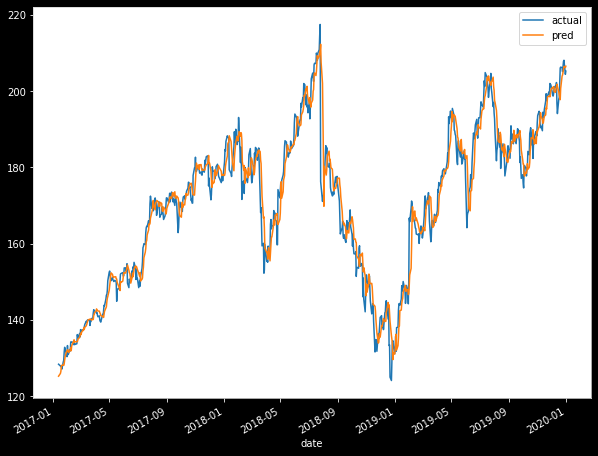

In [15]:
df_pred = validate(model, 'FB')
plot(df_pred)

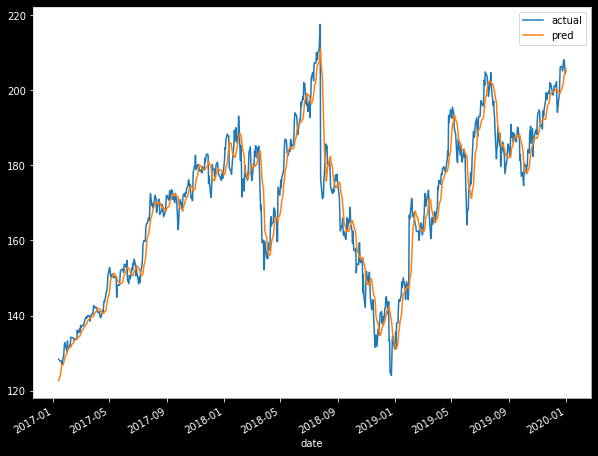

In [16]:
df_pred = validate(MeanModel(), 'FB')
plot(df_pred)

# Strategy

In [17]:
class SimpleStrategy:
  """Simple strategy

  If day's predicted change is positive, hold through day.
  If day's predicted change is negative, skip the day.
  """
  def __init__(self, model):
    self.model = model

  def compute_hold(self, ticker):
    df_pred = validate(self.model, ticker)
    df_pred = df_pred.dropna(subset=('actual', 'pred'))
    actual, pred = df_pred['actual'].values, df_pred['pred'].values
    assert len(actual) == len(pred)
    hold = pred[1:] > pred[:-1]
    return pd.DataFrame.from_dict({
        'actual': actual[1:],
        'pred': pred[1:],
        'hold': hold,
    })

def compute_returns(df):
  df = df.copy()
  df.loc[:, 'roi_actual'] = df.actual / df.actual.shift(1)
  df.loc[:, 'roi_pred'] = df.pred / df.pred.shift(1)
  return df

def total_return(df, query=None):
  if query:
    df = df.query(query)
  roi_actual = df.roi_actual.product()
  roi_pred = df.roi_pred.product()
  return roi_actual, roi_pred

def evaluate_models(models, tickers):
  strats = {name: SimpleStrategy(model) for name, model in models.items()}
  df_actual = pd.DataFrame()
  df_pred = pd.DataFrame()
  
  for ticker in tickers:
    for strat_name, strat in strats.items():
      df_hold = strat.compute_hold(ticker)
      df_roi = compute_returns(df_hold)
      
      all = total_return(df_roi)
      hold = total_return(df_roi, 'hold == True')
      not_hold = total_return(df_roi, 'hold == False')

      df_actual.loc[strat_name + ': all', ticker] = all[0]
      df_actual.loc[strat_name + ': hold', ticker] = hold[0]
      df_actual.loc[strat_name + ': !hold', ticker] = not_hold[0]
      df_pred.loc[strat_name + ': all', ticker] = all[1]
      df_pred.loc[strat_name + ': hold', ticker] = hold[1]
      df_pred.loc[strat_name + ': !hold', ticker] = not_hold[1]
  return df_actual, df_pred


In [18]:
models = {
    'mean': MeanModel(),
    'linear': model,
}
tickers = [
    'FB',
    'GOOG',
    'AAPL',
    'MSFT',
    'SPY',
]

df_actual, df_pred = evaluate_models(models, tickers)
df_actual

,FB,GOOG,AAPL,MSFT,SPY
mean: all,1.605146,1.661699,2.561681,2.661718,1.505768
mean: hold,1.191727,0.858176,1.725185,1.198620,1.311941
mean: !hold,1.346908,1.936316,1.484874,2.220653,1.147746
linear: all,1.605146,1.661699,2.561681,2.661718,1.505768
linear: hold,1.001639,1.032492,2.433386,1.100333,1.288130
linear: !hold,1.602517,1.609406,1.052723,2.419017,1.168961
